##PRODUCT RECOGNITION ON STORE SHELVES

### **Step A - Multiple Product Detection:**

In [ ]:
!pip install opencv-python==3.4.2.17

ERROR: Could not find a version that satisfies the requirement opencv-contrib-python<3.4 (from versions: 3.4.2.17, 3.4.3.18, 3.4.4.19, 3.4.5.20, 3.4.6.27, 3.4.7.28, 3.4.8.29, 3.4.9.31, 3.4.9.33, 3.4.10.35, 3.4.10.37, 3.4.11.39, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 4.0.0.21, 4.0.1.23, 4.0.1.24, 4.1.0.25, 4.1.1.26, 4.1.2.30, 4.2.0.32, 4.2.0.34, 4.3.0.36, 4.3.0.38, 4.4.0.40, 4.4.0.42, 4.4.0.44, 4.4.0.46, 4.5.1.48)
ERROR: No matching distribution found for opencv-contrib-python<3.4


In [ ]:
import numpy as np
from scipy.spatial import distance
import cv2
from matplotlib import pyplot as plt
from scipy import signal
import math
import nbconvert

In [ ]:
models=["0.jpg", "1.jpg", "11.jpg", "19.jpg", 
        "24.jpg", "25.jpg", "26.jpg"]
mod= [] #list of models images to be used as query

fig=plt.figure(figsize=(15, 10))
i=1
for el in models:
    img = cv2.imread(el)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mod.append(img_rgb) #appending the image to the list 
    fig.add_subplot(2, 4, i)
    plt.title(models[i-1])
    plt.imshow(img_rgb)
    i+=1
plt.show()

error: ignored

<Figure size 1080x720 with 0 Axes>

These are the model images that are gonna be matched in the scenes images.

After that we will save scenes images in a new list called mod_train.

In [ ]:
train = ["e1.png", "e2.png", "e3.png", "e4.png", "e5.png"]
mod_train= [] #list of models images to be used as query

for el in train:
    img_t = cv2.imread(el)
    img_rgb = cv2.cvtColor(img_t, cv2.COLOR_BGR2RGB)
    mod_train.append(img_rgb)#appending the image to the list 

We are going to set the parameters and initialize the matcher. The index for the kdtree is set to 1, the search parameter is set to 500 to obtain a better precision, with no particular time change, the program is not being slowed down.

In [ ]:
# Defining index for approximate kdtree algorithm
FLANN_INDEX_KDTREE = 1

# Defining parameters for algorithm 
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

# Defining search params.
# checks=50 specifies the number of times the trees in the index should be recursively traversed.
# Higher values gives better precision, but also takes more time
search_params = dict(checks = 500)

# Initializing matcher
flann = cv2.FlannBasedMatcher(index_params, search_params)

In [ ]:
colors= [(255, 0, 0),(0, 255, 0),(0, 0, 255),(0,255,255),(255,0, 255),(255, 255, 0),(139, 0, 139)]
res = dict.fromkeys(models , (0,(0,0),0,0))
tot = dict.fromkeys(train, res) #final dictionary for all the scenes

sift = cv2.xfeatures2d.SIFT_create()
x=0
while x in range(len(train)):
    print("\033[1m" + "\nTrying matches for image: " + str(train[x]) + "\033[0m")
    y=0
    res = dict.fromkeys(models , (0,(0,0),0,0)) #creating dictionary to save the results (istance found,location,width,height)
    while y in range(len(models)):
        
        #Keypoints and descriptor of model image
        kp_query = sift.detect(mod[y])
        kp_query, des_query = sift.compute(mod[y], kp_query)
        
        #Keypoints and descriptor of scene image
        kp_train = sift.detect(mod_train[x])
        kp_train, des_train = sift.compute(mod_train[x], kp_train)
    
        # Matching and finding the 2 closest elements for each query descriptor.
        matches = flann.knnMatch(des_query,des_train,k=2)
        
        good = [] #finding good matches
        for m,n in matches:
            if m.distance < 0.5*n.distance:
                good.append(m)
   
        # Checking if we found enough matching
        MIN_MATCH_COUNT = 50
        if len(good)>MIN_MATCH_COUNT:
            print("Matches Found: {} / {}".format(len(good),MIN_MATCH_COUNT) + " with "+ str(models[y]))
            # building the corrspondences arrays of good matches
            src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        # Using RANSAC to estimate a robust homography. 
        # It returns the homography M and a mask for the discarded points
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
        # Mask of discarded point used in visualization
            matchesMask = mask.ravel().tolist()
    
        # Corners of the query image
            h,w,r = mod[y].shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    
        # Projecting the corners into the train image
            dst = cv2.perspectiveTransform(pts,M)
        
        # Saving width and height of the bounding box
            dst=dst.astype(int)
            dst[dst<0]=0
            wh = np.max(dst, axis=0) - np.min(dst,axis=0)
    
        # Drawing the bounding box
            mod_train[x] = cv2.polylines(mod_train[x],[np.int32(dst)],True,colors[y],5, cv2.LINE_AA)
            res[models[y]]=(1,(wh[0][0]//2,wh[0][1]//2),wh[0][0],wh[0][1])
        
        else:
            print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) + " with " + str(models[y]) )
            matchesMask = None
        y+=1
    tot[train[x]]=res
    x+=1


Trying matches for image: e1.png
Matches Found: 145 / 50 with 0.jpg
Matches Found: 105 / 50 with 1.jpg
Matches Found: 62 / 50 with 11.jpg
Not enough matches are found - 0/50 with 19.jpg
Not enough matches are found - 0/50 with 24.jpg
Not enough matches are found - 4/50 with 25.jpg
Not enough matches are found - 25/50 with 26.jpg

Trying matches for image: e2.png
Not enough matches are found - 34/50 with 0.jpg
Not enough matches are found - 7/50 with 1.jpg
Not enough matches are found - 1/50 with 11.jpg
Not enough matches are found - 0/50 with 19.jpg
Matches Found: 131 / 50 with 24.jpg
Matches Found: 134 / 50 with 25.jpg
Matches Found: 150 / 50 with 26.jpg

Trying matches for image: e3.png
Matches Found: 122 / 50 with 0.jpg
Matches Found: 62 / 50 with 1.jpg
Not enough matches are found - 40/50 with 11.jpg
Not enough matches are found - 0/50 with 19.jpg
Not enough matches are found - 0/50 with 24.jpg
Not enough matches are found - 16/50 with 25.jpg
Not enough matches are found - 16/50 w


Processing the scene image: e1.png

Product 0.jpg - 1 instance found: 
	 Istance 1 {position: (156, 156), width: 313px, height: 439px}

Product 1.jpg - 1 instance found: 
	 Istance 1 {position: (149, 149), width: 299px, height: 360px}

Product 11.jpg - 1 instance found: 
	 Istance 1 {position: (151, 151), width: 302px, height: 362px}


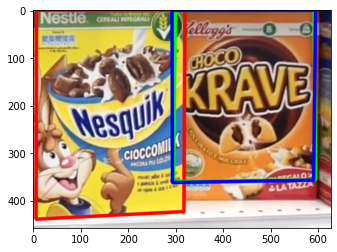


Processing the scene image: e2.png

Product 24.jpg - 1 instance found: 
	 Istance 1 {position: (168, 168), width: 337px, height: 466px}

Product 25.jpg - 1 instance found: 
	 Istance 1 {position: (160, 160), width: 321px, height: 443px}

Product 26.jpg - 1 instance found: 
	 Istance 1 {position: (168, 168), width: 337px, height: 463px}


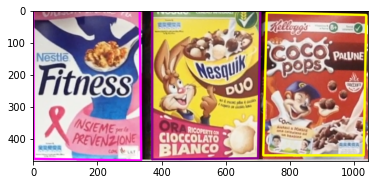


Processing the scene image: e3.png

Product 0.jpg - 1 instance found: 
	 Istance 1 {position: (163, 163), width: 327px, height: 451px}

Product 1.jpg - 1 instance found: 
	 Istance 1 {position: (152, 152), width: 304px, height: 382px}


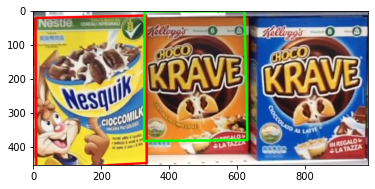


Processing the scene image: e4.png

Product 0.jpg - 1 instance found: 
	 Istance 1 {position: (161, 161), width: 322px, height: 452px}

Product 1.jpg - 1 instance found: 
	 Istance 1 {position: (151, 151), width: 302px, height: 391px}

Product 11.jpg - 1 instance found: 
	 Istance 1 {position: (152, 152), width: 304px, height: 398px}

Product 25.jpg - 1 instance found: 
	 Istance 1 {position: (165, 165), width: 331px, height: 435px}

Product 26.jpg - 1 instance found: 
	 Istance 1 {position: (172, 172), width: 344px, height: 444px}


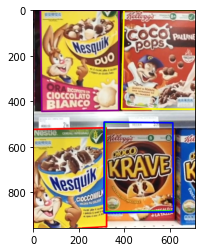


Processing the scene image: e5.png

Product 19.jpg - 1 instance found: 
	 Istance 1 {position: (150, 150), width: 300px, height: 383px}

Product 25.jpg - 1 instance found: 
	 Istance 1 {position: (162, 162), width: 324px, height: 449px}


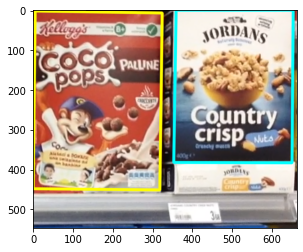

In [ ]:
for el in range(len(train)):
    print("\033[1m" + "\nProcessing the scene image: " + str(train[el]) + "\033[0m")
    for im in tot[train[el]]:
        if tot[train[el]][im][0]>0:
            print("\nProduct {} - {} instance found: ".format(im,tot[train[el]][im][0]))
            print("\t Istance {} {{position: {}, width: {}px, height: {}px}}".format(tot[train[el]][im][0],
                (tot[train[el]][im][1][0],tot[train[el]][im][1][0]),tot[train[el]][im][2],tot[train[el]][im][3]))
    plt.imshow(mod_train[el])
    plt.show()

### **Step B - Multiple Instance Detection:**

 **Functions description:**

*rotate(delta_phi,v)*


input:

  -	Delta_phi: difference of the canonical orientation wrt model and scene homologous points
  -	V: model point’s joining vector


Output: Return the predicted scene’s joining vector

---

*convert_AA(v,deltax,deltay)*

input:
  -	V: Accumulator Array bin’s index
  -	Deltax: Accumulator Array bin’s width
  -	Deltay: Accumulator Array bin’s heigh

Output: Return a list containing the bin’s range wrt x and y axis (in pixel)

---

*convert_AA_2(t,AA_img)*

input:
-	T: ratio threshold level wrt the highest voted bin
-	AA_img: Accumulator Array

Output: Return a dictionary containing the enough voted bins with the associated pixel range.

---

*matches(AA_dict,F_t_match)*

input:
-	AA_dict: Accumulator Array dictionary (from convert_AA_2)
-	F_t_match: list of scene features (that have been matched with model feature)

Output: Return a dictionary containing a list of scene feature’s indexes associated with the respective bin

---

*Convert_wh(v)* 

Input:
-	V: list (model images per scene image) of list (instance of the model) of values

Output: Return a dictionary version of the input list. Empty lists are deleted

---

In [ ]:
def rotate(delta_phi,v):
  theta = np.radians(delta_phi)
  c, s = np.cos(theta), np.sin(theta)
  R = np.array(((c, -s), (s, c)))
  return np.dot(R, v)
  
def convert_AA(v,deltax,deltay):
  v1 = []
  v1.append([int(v[0]*deltay), int(deltay*(v[0]+1))])
  v1.append([int(v[1]*deltax), int(deltax*(v[1]+1))])
  return v1

def convert_AA_2(t,AA_img):
  dictionary = {}
  n = 0
  trashold = t*np.max(AA_img)
  for i in range(AA_img.shape[0]):
    for j in range(AA_img.shape[1]):
      if AA_img[i,j] >= trashold:
        dictionary[n] = convert_AA([i,j], deltax, deltay)
        n += 1
  return dictionary

def matches(AA_dict,F_t_match):
  ind = {}
  for j in range(len(AA_dict.keys())):
    val = []
    for i in range(len(F_t_match)):
      if (F_t_match[i][4][0] > AA_dict[j][1][0]) and (F_t_match[i][4][0] < AA_dict[j][1][1]) and (F_t_match[i][4][0] > AA_dict[j][0][0]) and (F_t_match[i][4][1] < AA_dict[j][0][1]):
        val.append(i) # se il punto è nel AA allora il suo indice nel vettore m F_t_match
    ind[j] = val
  return ind

def convert_wh(w): 
  W = {}
  for el in range(n_mod):
    if len(w[el])>0:
      W[el] = w[el]
  return W

def nms(AA_img,t):
  kernel = np.array([[-1,-1,-1],[0,0,0],[1,1,1]])/3
  derx = signal.correlate(np.array(AA_img),kernel.transpose(),mode='same')
  dery = signal.correlate(np.array(AA_img),kernel,mode='same')
  grad_mag = np.maximum(np.abs(derx),np.abs(dery))
  atan = np.vectorize(math.atan)
  grad_dir = atan(np.array(derx)/np.array(dery))
  nms = np.array([[0]*(grad_mag.shape[0]+2)]*(grad_mag.shape[1]+2))
  nms[1:-1,1:-1] = grad_mag
  for row in range(grad_dir.shape[0]):
    for col in range(grad_dir.shape[1]):
      r = row + 1
      c = col + 1
      if ((grad_dir[row,col]>= -math.pi/8) and (grad_dir[row,col] < math.pi/8)) or ((grad_dir[row,col]>= 7*math.pi/8) and (grad_dir[row,col] < -7*math.pi/8 )):
        if (nms[r,c]< nms[r,c+1]) or (nms[r,c]< nms[r,c-1]):
          nms[r,c] = 0
      if ((grad_dir[row,col]>= math.pi/8) and (grad_dir[row,col] < 3*math.pi/8)) or ((grad_dir[row,col]>= -7*math.pi/8) and (grad_dir[row,col] < -5*math.pi/8 )):
        if (nms[r,c]< nms[r-1,c+1]) or (nms[r,c]< nms[r+1,c-1]):
          nms[r,c]  = 0
      if ((grad_dir[row,col]>= 3*math.pi/8) and (grad_dir[row,col] < 5*math.pi/8)) or ((grad_dir[row,col]>= -5*math.pi/8) and (grad_dir[row,col] < -3*math.pi/8 )):
        if (nms[r,c]< nms[r+1,c]) or (nms[r,c]< nms[r-1,c]):
          nms[r,c] = 0
      if ((grad_dir[row,col]>= 5*math.pi/8) and (grad_dir[row,col] < 7*math.pi/8)) or ((grad_dir[row,col]>= -3*math.pi/8) and (grad_dir[row,col] < -math.pi/8 )):
        if (nms[r,c]< nms[r-1,c-1]) or (nms[r,c]< nms[r+1,c+1]):
          nms[r,c] = 0
      grad_mag_nms = nms[1:-1,1:-1]
      for row in range(len(grad_mag_nms[0])):
        for col in range(len(grad_mag_nms[1])):
          if grad_mag_nms[row,col] < t:
            AA_img[row,col] = 0
    return AA_img

**Step 0**
 
Pre-processing

In [ ]:
models=["0.jpg", "1.jpg", "11.jpg", "19.jpg","24.jpg","25.jpg","26.jpg"]
colors= [(255, 0, 0),(0, 255, 0),(0, 0, 255),(0,255,255),(255,0, 255),(255, 255, 0),(139, 0, 139),(139, 139, 0)]
ratio = [0.9,0.8,0.8,0.9,0.5]
train_multi = ["m1.png", "m2.png", "m3.png", "m4.png", "m5.png"]
n_target= len(train_multi)
n_mod = len(models)

In [ ]:
img_t = [0 for m in range(n_target)]

**Step 1**

Search model images occurrences in each target image. Once found, record for 
each instance its position, width and high and the number of matched corresponding points – wid_hei_tar, dst_tar, scores_tar


In [ ]:
wid_hei_tar = []
scores_tar = []
dst_tar = []
for tar in range(n_target):
  wid_hei_mod = []
  scores_mod = []
  dst_mod = []
  print(f'''Processing the scene image {train_multi[tar]}''')
  img_target = cv2.imread(train_multi[tar])
  img_target = cv2.cvtColor(img_target, cv2.COLOR_BGR2RGB)
  img_t[tar] = img_target.copy()
  for mod in range(n_mod):
    feature = []
    scores_feature = []
    feature_dst = []
    img_query = cv2.imread(models[mod])
    img_query = cv2.cvtColor(img_query, cv2.COLOR_BGR2RGB)
    #percent by which the image is resized
    scale_percent = round((img_target.shape[0]*ratio[tar])/img_query.copy().shape[0]*100,1)
    width = int(img_query.shape[1] * scale_percent / 100)
    height = int(img_query.shape[0] * scale_percent / 100)
    dsize = (width, height)

    # resize image
    img_model = cv2.resize(img_query.copy(), dsize)

    # DETECTION

    #sift initialization
    sift = cv2.xfeatures2d.SIFT_create()

    #Keypoints and detection for the model image
    kp_model_multi = sift.detect(img_model)

    #Keypoints and detection for the train image
    kp_target_multi = sift.detect(img_target)

    # DESCRIPTION

    #Keypoints and descriptors for the model image
    kp_model_multi, des_model_multi = sift.compute(img_model, kp_model_multi)

    #Keypoints and descriptors for the train image
    kp_target_multi, des_target_multi = sift.compute(img_target, kp_target_multi)


    # GENERATING MODEL FEATURES
    F = []
    for i in range(len(kp_model_multi)): 
      F.append([np.array(kp_model_multi[i].pt), kp_model_multi[i].angle, kp_model_multi[i].size, des_model_multi[i]])

    # BARICENTER OF THE MODEL  
    Pc = np.array(F)[:,0].mean()

    # GENERATING TARGET FEATURES
    F_t = []
    for i in range(len(kp_target_multi)):
      F_t.append([kp_target_multi[i].pt, kp_target_multi[i].angle, kp_target_multi[i].size, des_target_multi[i]])

    # introducing the joining vecotors
    for i in range(len(kp_model_multi)): 
      F[i].append(Pc - kp_model_multi[i].pt)

    #FINDING MATCHES

    # Defining index for approximate kdtree algorithm
    FLANN_INDEX_KDTREE = 1

    # Defining parameters for algorithm 
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

    # Defining search params.
    # checks=500 specifies the number of times the trees in the index should be recursively traversed.
    # Higher values gives better precision, but also takes more time
    search_params = dict(checks = 500)

    # Initializing matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Matching and finding the 2 closest elements for each model descriptor.
    match_multi = flann.knnMatch(des_model_multi,des_target_multi,k=2)
    density = round(100*len(match_multi)/(img_query.shape[0]*img_query.shape[1]),2)

    # good value selection
    if (len(match_multi) > 800) and (len(match_multi) <= 1000):
      good_multi = []
      for m,n in match_multi:
        if m.distance < 0.7*n.distance:
            good_multi.append(m)

    elif (len(match_multi) > 1000) and (len(match_multi) < 1400):
      good_multi = []
      for m,n in match_multi:
        if m.distance < 0.6*n.distance:
            good_multi.append(m)

    else:
      good_multi = []
      for m,n in match_multi:
        if m.distance < 0.5*n.distance:
            good_multi.append(m)
    

    # CONFIDENCE VALUE selection
    if (density <= 0.06):
      MIN_MATCH_COUNT = 20
      CONFIDENCE = 0.7

    elif (density > 0.06) and (density <= 1.2):
      MIN_MATCH_COUNT = 7
      CONFIDENCE = 0.6

    elif (density > 1.2) and (density < 1.8):

      MIN_MATCH_COUNT = 15
      CONFIDENCE = 0.8

    else:
      MIN_MATCH_COUNT = 20
      CONFIDENCE = 0.9

    if len(good_multi)>1:
    
      # FILTERING THE FEATURE VECTORS WRT GOOD MATCHES ONLY
      F_match = [ F[m.queryIdx] for m in good_multi ]
      F_t_match = [ F_t[m.trainIdx] for m in good_multi ]


      #NG SCHEME WRT BARICENTER
      Pc_t = []
      for i in range(len(F_t_match)):
        delta_phi = F_match[i][1] - F_t_match[i][1]
        s = F_match[i][2] / F_t_match[i][2]
        Pc_t.append(F_t_match[i][0] + s*rotate(delta_phi,F_match[i][4]))

      a = []
      img_copy = img_target.copy()
      for i in range(len(Pc_t)):
        a.append(Pc_t[i].tolist())
      Pc_t = np.array(a)

      # introducing the estimeted baricenter wrt F_t_match
      for el in range(len(F_t_match)):
        F_t_match[el].append(Pc_t[el])

      #ACCUMULATOR ARRAY: QUANTIZATION OF THE HOUGH SPACE
      range_ = [[0, img_target.shape[1]], [0, img_target.shape[0]]]
      bins = 6
      deltay = img_target.shape[0]/bins
      deltax = img_target.shape[1]/bins


      hist = plt.hist2d(Pc_t[:,0],Pc_t[:,1],range = range_, bins = bins,)
      AA = hist[0]
      AA_img = np.array(AA).transpose()
      AA_dict = convert_AA_2(CONFIDENCE, AA_img)
      #AA_img = nms(AA_img,18)
      kp_per_Ptc = matches(AA_dict, F_t_match)
      

      for i in range(len(kp_per_Ptc.keys())):
        if len(kp_per_Ptc[i])>0:
          # Checking if we found enough matching
          if len(kp_per_Ptc[i]) > MIN_MATCH_COUNT:
            # building the corrspondences arrays of good matches
            src_pts_multi = np.float32([ F_match[m][0] for m in kp_per_Ptc[i] ]).reshape(-1,1,2)
            dst_pts_multi = np.float32([ F_t_match[m][0] for m in kp_per_Ptc[i] ]).reshape(-1,1,2)
            # Using RANSAC to estimate a robust homography. 
            # It returns the homography M and a mask for the discarded points
            M_multi, mask_multi = cv2.findHomography(src_pts_multi, dst_pts_multi, cv2.RANSAC, 5.0)
            
            # Mask of discarded point used in visualization
            matchesMask = mask_multi.ravel().tolist()
            
            # Corners of the query image
            h,w,l = img_model.shape
            pts_multi = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            
            # Projecting the corners into the train image
            dst_multi = cv2.perspectiveTransform(pts_multi, M_multi)

            dst_multi = dst_multi.astype(int)
            dst_multi[dst_multi<0]=0

            wh =[dst_multi[0][0].tolist(),dst_multi[2][0].tolist()]
            feature.append(wh)
            feature_dst.append(dst_multi)
            scores_feature.append(len(kp_per_Ptc[i]))
            
          else:  matchesMask = None
  
    wid_hei_mod.append(feature)
    dst_mod.append(feature_dst)
    scores_mod.append(scores_feature)
  wid_hei_tar.append(wid_hei_mod)
  scores_tar.append(scores_mod)
  dst_tar.append(dst_mod)
        
    


**Step 2**

Filter out overlapping windows:

Given two overlapping windows (Euclidian distance wrt the position of the two windows’ barycenter less than a given threshold) select that one with higher number of found corresponding point and suppress the other.


In [ ]:
dict_wh = []
dict_scores = []
dict_dst = []

for tar in range(n_target):
    dict_wh.append(convert_wh(wid_hei_tar[tar]))
    dict_scores.append(convert_wh(scores_tar[tar]))
    dict_dst.append(convert_wh(dst_tar[tar]))

p_tar = []
for tar in range(n_target):
  p = []
  for mod in dict_wh[tar].keys():
    for el in range(len(dict_wh[tar][mod])):
      width_len = np.abs(np.array(dict_wh[tar][mod][el][0]) - np.array(dict_wh[tar][mod][el][1])).tolist()
      w = width_len[0]
      l = width_len[1]
      posx = dict_wh[tar][mod][el][0][0]+w//2
      posy = dict_wh[tar][mod][el][0][1]+l//2
      p.append([np.array((posx,posy)),(mod,el)])
  p_tar.append(p)

d_tar = []
for tar in range(n_target):
  d = []
  for el1 in range(len(p_tar[tar])):
    for el2 in range(el1,len(p_tar[tar])):
      if el1 != el2:
        dis = int(distance.euclidean(p_tar[tar][el1][0],p_tar[tar][el2][0]))
        d.append([dis,[p_tar[tar][el1][1],p_tar[tar][el2][1]]])
  d_tar.append(d)   

dict_wh1 = dict_wh
dict_scores1 = dict_scores

for tar in range(n_target):
  for el in range(len(d_tar[tar])):
    if d_tar[tar][el][0] < 100:
      mod1 = d_tar[tar][el][1][0][0]
      ist1 = d_tar[tar][el][1][0][1]
      mod2 = d_tar[tar][el][1][1][0]
      ist2 = d_tar[tar][el][1][1][1]
      if dict_scores[tar][mod1][ist1] < dict_scores[tar][mod2][ist2]:
        dict_wh1[tar][mod1][ist1].clear()
        dict_scores1[tar][mod1][ist1]
      else:
        dict_wh1[tar][mod2][ist2].clear()
        dict_scores1[tar][mod2][ist2] = 0

**Step 3**

Print out the final results



  Processing the scene image: m1.png 

        Product 24.jpg - instance found: 2 

            - Istance 1 position: (184,232), width: 364px, height: 465px

            - Istance 2 position: (548,232), width: 339px, height: 465px

        Product 25.jpg - instance found: 1 

            - Istance 1 position: (1262,230), width: 303px, height: 449px

        Product 26.jpg - instance found: 1 

            - Istance 1 position: (919,229), width: 330px, height: 459px


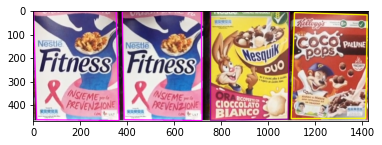


  Processing the scene image: m2.png 

        Product 0.jpg - instance found: 1 

            - Istance 1 position: (179,298), width: 346px, height: 439px

        Product 1.jpg - instance found: 1 

            - Istance 1 position: (848,253), width: 313px, height: 409px

        Product 11.jpg - instance found: 1 

            - Istance 1 position: (510,249), width: 311px, height: 403px


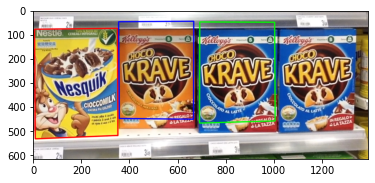


  Processing the scene image: m3.png 

        Product 19.jpg - instance found: 1 

            - Istance 1 position: (1233,190), width: 290px, height: 381px

        Product 25.jpg - instance found: 2 

            - Istance 1 position: (558,227), width: 331px, height: 455px

            - Istance 2 position: (889,225), width: 311px, height: 446px

        Product 26.jpg - instance found: 1 

            - Istance 1 position: (192,229), width: 365px, height: 458px


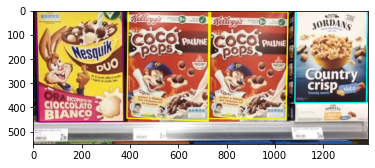


  Processing the scene image: m4.png 

        Product 24.jpg - instance found: 2 

            - Istance 1 position: (176,223), width: 352px, height: 447px

            - Istance 2 position: (540,224), width: 360px, height: 448px

        Product 25.jpg - instance found: 2 

            - Istance 1 position: (1262,204), width: 304px, height: 409px

            - Istance 2 position: (1589,215), width: 296px, height: 430px

        Product 26.jpg - instance found: 1 

            - Istance 1 position: (920,220), width: 344px, height: 440px


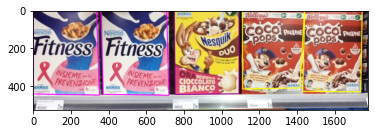


  Processing the scene image: m5.png 

        Product 11.jpg - instance found: 1 

            - Istance 1 position: (830,713), width: 300px, height: 408px

        Product 19.jpg - instance found: 1 

            - Istance 1 position: (911,192), width: 292px, height: 384px

        Product 25.jpg - instance found: 2 

            - Istance 1 position: (241,246), width: 350px, height: 492px

            - Istance 2 position: (607,308), width: 353px, height: 591px


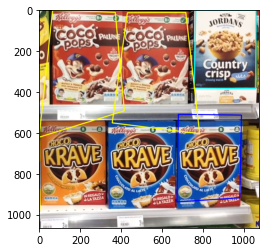

In [ ]:
for tar in range(n_target):
  print(f'''\033[1m
  Processing the scene image: {train_multi[tar]} \033[0m''')
  for mod in dict_wh1[tar].keys():
    j = 0
    if dict_wh1[tar][mod] != [[]]:
      n_instance = len(dict_wh1[tar][mod]) - dict_wh1[tar][mod].count([])
      if n_instance > 0 :
        print(f'''
        Product {models[mod]} - instance found: {n_instance} ''')
        for el in range(len(dict_wh1[tar][mod])):
          if len(dict_wh1[tar][mod][el]) != 0: 
            j+=1
            img_t[tar] = cv2.polylines(img_t[tar],[np.int32(dict_dst[tar][mod][el])],True,colors[mod],3, cv2.LINE_AA)
            width_len = np.abs(np.array(dict_wh1[tar][mod][el][0]) - np.array(dict_wh1[tar][mod][el][1])).tolist()
            w = width_len[0]
            l = width_len[1]
            posx = dict_wh1[tar][mod][el][0][0]+w//2
            posy = dict_wh1[tar][mod][el][0][1]+l//2
            print(f'''
            - Istance {j} position: ({posx},{posy}), width: {w}px, height: {l}px''')
  plt.imshow(img_t[tar])
  plt.show()

        
        